In [11]:
import glob
import cv2
import matplotlib.pyplot as plt
from PIL import Image, ImageOps, ImageFilter
from skimage import data, io, filters
from skimage import feature as ft
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
from collections import Counter
import random
from skimage import util
import numpy as np  
import matplotlib.mlab as mlab  

### 1.Reading images

In [12]:
dataset_path = "../images"

X = []
y = []
for i in glob.glob(dataset_path + '/*.png', recursive=True):
    
    label = i.split("images")[1][1:4]
    y.append(label)
    # write code to read ecah file i, and append it to list X
    X.append(cv2.imread(i))


# you should have X, y with 5998 entries on each.
print(len(y))
print(len(X))

5998
5998


### 2.Pre-processing images

#### 2.1 equalize to make the samples distribute more uniformly

In [13]:
# 统计每种标志的个数，并记录在valuelist中
counter={}
for i in y:
     #List.count(i)统计列表元素对应的个数
    if y.count(i) > 0:
        counter[i] = y.count(i)
valuelist=[]
for key, value in counter.items():
    valuelist.append(value)
print(np.mean(valuelist))
print(np.median(valuelist))

# 切片
sliceList_X=[]
sliceList_y=[]
start=0
for i in range (0,len(valuelist)):
    sliceList_y.append(y[start:start+valuelist[i]])
    sliceList_X.append(X[start:start+valuelist[i]])
    start=start+valuelist[i]

# 补齐至62项(中位数)
for i in range (0,len(valuelist)):
    if valuelist[i]<62:
        n=62-valuelist[i]
        k=0
        for j in range(0,n):            
            sliceList_y[i].append(sliceList_y[i][k])
            sliceList_X[i].append(sliceList_X[i][k])
            k=k+1
            if k==valuelist[i]:
                k=0
                
# 合并
y=[]
X=[]
for i in range (0,len(valuelist)):
    y.extend(sliceList_y[i])
    X.extend(sliceList_X[i])

print(len(X))
print(len(y))

103.41379310344827
62.0
7012
7012


#### 2.2 rotate +-10degree, +-15degree,  each 5%

In [14]:
def rotate(image, angle):
    (h, w) = image.shape[:2]  # 返回(高,宽,色彩通道数),此处取前两个值返回
    # 抓取旋转矩阵(应用角度的负值顺时针旋转)。参数1为旋转中心点;参数2为旋转角度,正的值表示逆时针旋转;参数3为各向同性的比例因子
    M = cv2.getRotationMatrix2D((w / 2, h / 2), -angle, 1.0)
    # 计算图像的新边界维数
    newW = int((h * np.abs(M[0, 1])) + (w * np.abs(M[0, 0])))
    newH = int((h * np.abs(M[0, 0])) + (w * np.abs(M[0, 1])))
    # 调整旋转矩阵以考虑平移
    M[0, 2] += (newW - w) / 2
    M[1, 2] += (newH - h) / 2
    # 执行实际的旋转并返回图像
    return cv2.warpAffine(image, M, (newW, newH)) # borderValue 缺省，默认是黑色

def augmentation_rotate (X,y,ratio):
    select_15=[]
    select_n15=[]
    select_10=[]
    select_n10=[]
    n=int(len(y)*ratio)
    for i in range(0,n):
        select_15.append(random.randint(0,len(y)-1))
    for i in range(0,n):
        select_n15.append(random.randint(0,len(y)-1))
    for i in range(0,n):
        select_10.append(random.randint(0,len(y)-1))
    for i in range(0,n):
        select_n10.append(random.randint(0,len(y)-1))

    X_rotated=X.copy()

    for i in select_15:
        X_rotated[i]=rotate(X_rotated[i],15)
    for i in select_n15:
        X_rotated[i]=rotate(X_rotated[i],-15)
    for i in select_10:
        X_rotated[i]=rotate(X_rotated[i],5)
    for i in select_n10:
        X_rotated[i]=rotate(X_rotated[i],-5)
    
    return X_rotated

#### 2.3 add Gaussian white noise to 20% of the images

In [15]:
def augmentation_noise (X,y,ratio):
    select=[]
    n=int(len(y)*ratio)
    for i in range(0,n):
        select.append(random.randint(0,len(y)-1))
    
    X_noisy=X.copy()
    for i in select:
        X_noisy[i]=util.random_noise(X_noisy[i],mode='gaussian')
    
    return X_noisy

#### 2.4 do affine transform to 20% of the images

In [16]:
def affine(image):
    rows,cols=image.shape[:2]
    point1=np.float32([[20,80],[300,50],[80,200]])
    point2=np.float32([[10,100],[300,50],[100,250]])
    M=cv2.getAffineTransform(point1,point2)
    image=cv2.warpAffine(image,M,(cols,rows),borderValue=(255,255,255))
    return image
    
def augmentation_affine(X,y,ratio):
    select=[]
    n=int(len(y)*ratio)
    for i in range(0,n):
        select.append(random.randint(0,len(y)-1))
    
    X_affine=X.copy()
    for i in select:
        X_affine[i]=affine(X_affine[i])
    
    return X_affine

#### 2.5 random crop 20% of the images

In [17]:
def random_crop(image, min_ratio, max_ratio):
        h, w = image.shape[:2]
        ratio = random.random()   
        scale = min_ratio + ratio * (max_ratio - min_ratio)    
        new_h = int(h*scale)    
        new_w = int(w*scale)   
        y = np.random.randint(0, h - new_h)    
        x = np.random.randint(0, w - new_w)   
        image = image[y:y+new_h, x:x+new_w, :]  
        return image

def augmentation_crop(X,y,ratio):
    select=[]
    n=int(len(y)*ratio)
    for i in range(0,n):
        select.append(random.randint(0,len(y)-1))
        
    X_crop=X.copy()
    for i in select:
        X_crop[i]=random_crop(X_crop[i],0.6,1)
        
    return X_crop

In [18]:
# use one of these transforms
#X_rotated=augmentation_rotate(X,y,0.05)
#X_noisy=augmentation_noise(X,y,0.2)
#X_affine=augmentation_affine(X,y,0.2)
#X_crop=augmentation_crop(X,y,0.2)

#### 2.X Preview these transforms

In [19]:
def previewTrasnform(X,y):
    i=random.randint(0,len(y)-1)
    
    fig = plt.figure()
    fig.add_subplot(1,2,1)
    plt.imshow(X[i])
    plt.title('original')
    fig.add_subplot(1, 2, 2)
    plt.imshow(util.random_noise(X[i],mode='gaussian'))
    plt.title('noisy')
    
    fig = plt.figure()
    fig.add_subplot(1, 2,1)
    plt.imshow(affine(X[i]))
    plt.title('affined')
    fig.add_subplot(1, 2, 2)
    plt.imshow(rotate(X[i],15))
    plt.title('rotated')
    
    fig = plt.figure()
    fig.add_subplot(1, 2, 1)
    plt.imshow(random_crop(X[i],0.6,1))
    plt.title('cropped')

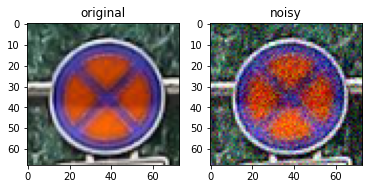

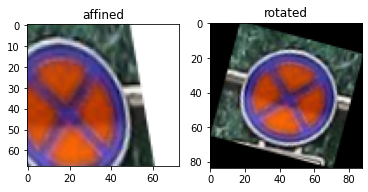

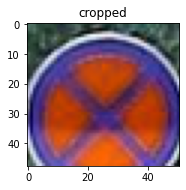

In [20]:
previewTrasnform(X,y)

#### *all transforms used 

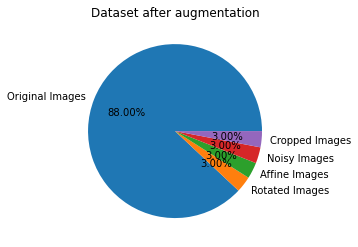

In [21]:
X1=augmentation_rotate(X,y,0.01)
X2=augmentation_affine(X1,y,0.03)
X3=augmentation_noise(X2,y,0.03)
X4=augmentation_crop(X3,y,0.03)

labels=['Original Images','Rotated Images','Affine Images','Noisy Images','Cropped Images']
R=[88,3,3,3,3]  
fig = plt.figure()
plt.pie(R,labels=labels,autopct='%1.2f%%') #画饼图（数据，数据对应的标签，百分数保留两位小数点）
plt.title("Dataset after augmentation")
plt.show() 

#### 2.6 resize48by48 & grayscale

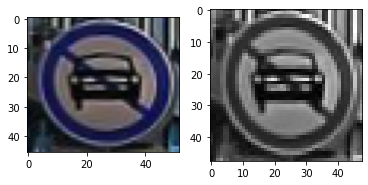

In [22]:
X_processed=[]
for x in X1:
    # Write code to resize image x to 48x48 and store in temp_x
    temp_x = cv2.resize(x, (48, 48))
    # Write code to convert temp_x to grayscale
    temp_x = cv2.cvtColor(temp_x, cv2.COLOR_BGR2GRAY)
    # equalize histogram
    #temp_x = cv2.equalizeHist(temp_x)
    # Append the converted image into X_processed
    X_processed.append(temp_x)
    
fig = plt.figure()
fig.add_subplot(1,2,1)
plt.imshow(X[0])
fig.add_subplot(1, 2, 2)
plt.imshow(X_processed[0],cmap='gray')

### 3.Calculating Features

In [23]:
X_features = []
for x in X_processed:
    x_feature = ft.hog(x, orientations=8, pixels_per_cell=(10, 10),cells_per_block=(1, 1), visualize=False, multichannel=False)
    X_features.append(x_feature)

### 4.training and testing classifiers

In [24]:
for i in range (0,10):
    X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size = 0.2)
    #SVM
    accuracy_SVM=[]
    clf = svm.SVC()
    clf.fit(X_train, y_train)
    accuracy_SVM.append(clf.score(X_test, y_test))
print('SVM:',np.mean(accuracy_SVM))

SVM: 0.9451176051318603


### 5. K_fold validation

In [25]:
def k_fold_validation(X, y, k, clf_type):
    # split the dataset
    split_len = int(len(X) / k) + 1
    splitted_X = []
    splitted_y = []
    score = 0
    for i in range(k):
        splitted_X.append(X[i*split_len:(i+1)*split_len])
        splitted_y.append(y[i*split_len:(i+1)*split_len])
    for i in range(k):
        X_test = splitted_X[i]
        y_test = splitted_y[i]
        X_train = []
        y_train = []
        for j in range(k):
            if j == i:
                continue
            for item in splitted_X[j]:
                X_train.append(item)
            for item in splitted_y[j]:
                y_train.append(item)
        # Create classifier for the method
        knn = False
        if clf_type == 'SVM':
            clf = svm.SVC()
        elif clf_type == 'RandomForest':
            clf = RandomForestClassifier()
        elif clf_type == 'Gaussian':
            clf = GaussianNB()
        else:
            knn = True
        # Train and test using the method
        if not knn:
            clf.fit(X_train, y_train)
            score += clf.score(X_test, y_test)
        else:
            result = []
            for i in range(1, 6):
                kneighclf = KNeighborsClassifier(n_neighbors=2*i-1)
                kneighclf.fit(X_train, y_train)
                result.append(kneighclf.score(X_test, y_test))
            score += max(result)
    return score / k

In [26]:
print("Average score:", k_fold_validation(X_features, y, 5, 'SVM'))

Average score: 0.917432033397821
